<p style="text-align: center;"><b>Fase 2 : Estudio de los datos<br>
Proyecto de Fin de Máster [2020 - 2021]<br>
Máster Universitario en Software y Sistemas [MUSS]<br>

#### Importar las librerías necesarias

In [2]:
# Operaciones númericas
import numpy as np
import pandas as pd, json
from math import radians, cos, sin, asin, sqrt

# Manejo del tiempo
import datetime
import time

# Convertir de Grados decimales a UTM.
from pyproj import Proj
import utm

# Para la visualización
import matplotlib.pyplot as plt, time
%matplotlib inline
from matplotlib import style
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Visualización del mapa
import folium
from folium.plugins import HeatMap, HeatMapWithTime

# Algoritmo de Convex hull.
from scipy.spatial.distance import squareform
from scipy.spatial import ConvexHull 

# Algoritmos de Minería de datos
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors 
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as shc
from st_dbscan import ST_DBSCAN
from st_optics import ST_OPTICS

# Coeficientes: Silhouette y Cophenet.
from sklearn import metrics
from scipy.cluster.hierarchy import cophenet

# Ignorar mensajes de warnings
import warnings
warnings.filterwarnings('ignore')
sns.set()

ModuleNotFoundError: No module named 'utm'

## Importar los datos

In [ ]:
# Leer los datos
Data = pd.read_csv("./Datos/Junio2020-04bf9c45-1eb7-4f3e-9ee2-61b3f6f2791f.csv")

# Renombrar las columnas.
Columns = Data.columns
Data = Data.rename(columns={Columns[0]:'Longitude(X)',Columns[1]:'Latitude(Y)'})

# Extresar el tiempo en segundos por épocas y pasar a intervalos de 30 min. 
Data['time'] = Data.apply (lambda row: time.mktime(time.strptime(row['datecreated'], '%Y-%m-%d %H:%M:%S')), axis=1)
Data['time'] = round(Data['time']/3600,0)

# Datecreated data from str to datetime type.
Data['datecreated'] = pd.to_datetime(Data['datecreated'])

#Data.info()
#Data

## 1. Preprocesamiento

### Cantidad de decimales

In [ ]:
# Precisión de 0.11m +- 5%
Data["Longitude(X)"] = round(Data["Longitude(X)"],6)
Data["Latitude(Y)"] = round(Data["Latitude(Y)"],6)

### 1.1 Ruido [Instancia temporal]

In [ ]:
# Se eliminan los datos que hayan sido registrados en una frecuencia menor a la establecida.
Data['deltaTime'] = Data['datecreated'].diff()
Data['deltaTime'] = round(pd.to_timedelta(Data['deltaTime']).dt.total_seconds(),2)
Data.drop(Data[Data['deltaTime'] < 45].index, inplace=True)
#Data.to_csv('Datos resultantes/Junio2020/Junio2020-SinRuido.csv')

#Data = Data.reset_index(drop=True)
#Data.info()
Data

,Longitude(X),Latitude(Y),datecreated,time,deltaTime
0,-76.508393,3.497531,2020-06-01 05:29:52,441939.0,NaN
6,-76.508379,3.497544,2020-06-01 05:31:29,441940.0,50.0
7,-76.508379,3.497544,2020-06-01 05:32:33,441940.0,64.0
8,-76.507837,3.497117,2020-06-01 05:33:29,441940.0,56.0
9,-76.509273,3.492992,2020-06-01 05:34:31,441940.0,62.0
...,...,...,...,...,...
5735,-76.508477,3.497618,2020-06-30 11:31:28,442642.0,722.0
5747,-76.508471,3.497645,2020-06-30 11:42:02,442642.0,605.0
5751,-76.508495,3.497624,2020-06-30 11:48:14,442642.0,364.0
5756,-76.508495,3.497624,2020-06-30 12:17:59,442642.0,1771.0


### 1.2 Puntos estacionarios

#### Duplicados

In [ ]:
# Obtengo los duplicados.

Duplicates = Data[Data.sort_values('datecreated').duplicated(['Longitude(X)','Latitude(Y)'], False)]
Duplicates.info()
#Duplicates.to_csv('Datos resultantes/Junio2020/Junio2020-Duplicados.csv')

# Elimino los duplicados cuya diferencia temporal sea menor a 1350, porque corresponden a los transitorios, no staypoints.
Duplicates.drop(Duplicates[Duplicates['deltaTime'] < 1350].index, inplace=True)
cols = ['Longitude(X)','Latitude(Y)']
Duplicates= Duplicates.sort_values('datecreated').drop_duplicates(['Longitude(X)','Latitude(Y)'])
Duplicates = Duplicates.reset_index(drop=True)
Duplicates.info()
Duplicates
#Duplicates.to_csv('Datos resultantes/Junio2020/Junio2020-EstacionariosDensidad.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2145 entries, 6 to 5757
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude(X)  2145 non-null   float64       
 1   Latitude(Y)   2145 non-null   float64       
 2   datecreated   2145 non-null   datetime64[ns]
 3   time          2145 non-null   float64       
 4   deltaTime     2145 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 100.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude(X)  101 non-null    float64       
 1   Latitude(Y)   101 non-null    float64       
 2   datecreated   101 non-null    datetime64[ns]
 3   time          101 non-null    float64       
 4   deltaTime     101 non-null    float64       
dtypes: datetime64[ns](1), fl

,Longitude(X),Latitude(Y),datecreated,time,deltaTime
0,-76.502659,3.502985,2020-06-01 06:10:04,441940.0,1790.0
1,-76.500660,3.504098,2020-06-01 07:52:14,441942.0,1791.0
2,-76.341895,3.513129,2020-06-01 10:59:00,441945.0,1784.0
3,-76.500583,3.504186,2020-06-01 14:26:11,441948.0,1796.0
4,-76.341703,3.513318,2020-06-01 17:54:43,441952.0,1785.0
...,...,...,...,...,...
96,-76.508453,3.497836,2020-06-27 15:22:19,442573.0,1791.0
97,-76.508444,3.497485,2020-06-27 20:12:46,442578.0,2398.0
98,-76.508443,3.497550,2020-06-27 22:08:19,442580.0,1548.0
99,-76.508570,3.497603,2020-06-30 11:05:11,442641.0,7202.0


#### Puntos de reposo prolongado

In [ ]:
parqueaderos = Data.loc[Data['deltaTime'] > 1850]
parqueaderos.reset_index(drop=True)
Estacionarios = pd.concat([Duplicates, parqueaderos], axis=0)
Estacionarios = Estacionarios.reset_index(drop=True)
Estacionarios

,Longitude(X),Latitude(Y),datecreated,time,deltaTime
0,-76.502659,3.502985,2020-06-01 06:10:04,441940.0,1790.0
1,-76.500660,3.504098,2020-06-01 07:52:14,441942.0,1791.0
2,-76.341895,3.513129,2020-06-01 10:59:00,441945.0,1784.0
3,-76.500583,3.504186,2020-06-01 14:26:11,441948.0,1796.0
4,-76.341703,3.513318,2020-06-01 17:54:43,441952.0,1785.0
...,...,...,...,...,...
159,-76.508444,3.497485,2020-06-27 21:18:43,442579.0,2176.0
160,-76.508443,3.497550,2020-06-28 01:34:44,442584.0,7256.0
161,-76.508486,3.497650,2020-06-30 07:59:51,442638.0,195907.0
162,-76.508570,3.497603,2020-06-30 11:05:11,442641.0,7202.0


In [ ]:
# Reducir los Estacionarios por densidad (Muchos puntos en una area) a puntos específicos.
Estacionarios = Estacionarios.sort_values('datecreated')
Estacionarios = Estacionarios.groupby(Estacionarios['datecreated'],as_index=False).first()

# Resumo a un único punto aquellos que estan a una distancia de máximo 500m. 
dicts = []; dicts2 = []; coord = []
for i, row in Estacionarios.iterrows():
    mydict = {}; Dates = []; Deltas = [];
    for j, row2 in Estacionarios.iterrows():
        mydict2 = {};
        if (abs(Estacionarios.at[i, 'Longitude(X)'] - row2['Longitude(X)']) <= 0.005).sum() and (abs(Estacionarios.at[i, 'Latitude(Y)'] - row2['Latitude(Y)']) <= 0.005).sum() and row2['Longitude(X)'] not in coord:
            coord.append(row2['Longitude(X)']); Dates.append(str(row2['datecreated'])); Deltas.append(row2['deltaTime']);
            mydict2["Longitude(X)"] = row2['Longitude(X)']; mydict2["Latitude(Y)"] = row2['Latitude(Y)']
            mydict2["datecreated"] = row2['datecreated']; mydict2["deltaTime"] = row2['deltaTime']
            dicts2.append(mydict2)
            
    mydict["Longitude(X)"] = row['Longitude(X)']
    mydict["Latitude(Y)"] = row['Latitude(Y)']
    mydict["datecreated"] =  row["datecreated"] # Necesario para el mapa de calor 
    mydict["Cantidad"] = len(Dates)
    mydict["Dates"] = Dates
    mydict["Deltas"] = Deltas
    if len(Dates) != 0:
        dicts.append(mydict)

EstacionariosPointOrder = pd.DataFrame(dicts2)
EstacionariosPoint = pd.DataFrame(dicts)
EstacionariosPoint.info()
EstacionariosPoint

# Puntos Estacionarios reducidos. 
#EstacionariosPointOrder.to_csv('Datos resultantes/Junio2020/Junio2020-EstacionariosPuntos-Ordenados.csv')
#EstacionariosPoint.to_csv('Datos resultantes/Junio2020/Junio2020-EstacionariosPuntos.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude(X)  7 non-null      float64       
 1   Latitude(Y)   7 non-null      float64       
 2   datecreated   7 non-null      datetime64[ns]
 3   Cantidad      7 non-null      int64         
 4   Dates         7 non-null      object        
 5   Deltas        7 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 464.0+ bytes


,Longitude(X),Latitude(Y),datecreated,Cantidad,Dates,Deltas
0,-76.502659,3.502985,2020-06-01 06:10:04,16,"[2020-06-01 06:10:04, 2020-06-01 07:52:14, 202...","[1790.0, 1791.0, 1796.0, 1793.0, 1794.0, 1797...."
1,-76.341895,3.513129,2020-06-01 10:59:00,57,"[2020-06-01 10:59:00, 2020-06-01 17:54:43, 202...","[1784.0, 1785.0, 1783.0, 7157.0, 1793.0, 1788...."
2,-76.508262,3.497718,2020-06-02 14:52:27,34,"[2020-06-02 14:52:27, 2020-06-03 05:36:02, 202...","[1791.0, 12640.0, 1794.0, 1779.0, 13888.0, 179..."
3,-76.386452,3.553948,2020-06-03 14:42:33,10,"[2020-06-03 14:42:33, 2020-06-03 16:02:51, 202...","[1790.0, 1790.0, 1800.0, 1937.0, 1796.0, 1792...."
4,-76.485171,3.461421,2020-06-06 11:42:29,3,"[2020-06-06 11:42:29, 2020-06-13 09:55:36, 202...","[1790.0, 1792.0, 1793.0]"
5,-76.359431,3.274708,2020-06-17 08:11:14,2,"[2020-06-17 08:11:14, 2020-06-17 11:15:22]","[1720.0, 1795.0]"
6,-76.505684,3.478893,2020-06-18 12:28:23,1,[2020-06-18 12:28:23],[1754.0]


### 1.3 Conversiones

In [ ]:
# Coordenadas geográficas a UTM.
Data = Data.sort_values('datecreated').drop_duplicates(['Longitude(X)','Latitude(Y)'], keep=False)
UTM = Proj("+proj=utm +zone=18U19U, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
Data['LonUTM(X)'],Data['LatUTM(Y)'] = UTM(Data["Longitude(X)"],Data["Latitude(Y)"])
Data['LonUTM(X)'] = round(Data['LonUTM(X)'],2)
Data['LatUTM(Y)'] = round(Data['LatUTM(Y)'],2)

#Data.to_csv('Datos resultantes/Junio2020/Junio2020-PuntosFinales.csv')
Data.info()
Data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 5747
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude(X)  1571 non-null   float64       
 1   Latitude(Y)   1571 non-null   float64       
 2   datecreated   1571 non-null   datetime64[ns]
 3   time          1571 non-null   float64       
 4   deltaTime     1570 non-null   float64       
 5   LonUTM(X)     1571 non-null   float64       
 6   LatUTM(Y)     1571 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 98.2 KB


,Longitude(X),Latitude(Y),datecreated,time,deltaTime,LonUTM(X),LatUTM(Y)
0,-76.508393,3.497531,2020-06-01 05:29:52,441939.0,NaN,332444.82,386721.66
8,-76.507837,3.497117,2020-06-01 05:33:29,441940.0,56.0,332506.52,386675.78
9,-76.509273,3.492992,2020-06-01 05:34:31,441940.0,62.0,332346.24,386219.92
10,-76.509934,3.490865,2020-06-01 05:35:30,441940.0,59.0,332272.42,385984.85
11,-76.509183,3.492598,2020-06-01 05:36:29,441940.0,59.0,332356.17,386176.34
...,...,...,...,...,...,...,...
5665,-76.508464,3.497554,2020-06-30 08:30:14,442639.0,1787.0,332436.94,386724.21
5666,-76.508501,3.497558,2020-06-30 08:32:15,442639.0,121.0,332432.83,386724.66
5681,-76.508477,3.497508,2020-06-30 08:55:46,442639.0,1322.0,332435.49,386719.13
5689,-76.508471,3.497578,2020-06-30 09:02:23,442639.0,387.0,332436.16,386726.87


### Asignaciones

In [ ]:
# arrayData[[Longitude, Latitude, datecreated, LonUTM, LatUTM, time]]
# Para: Gráfica 3D
arrayData = (Data.iloc[:,[0,1,2,5,6,3]]).values

# Location[[Longitude, Latitude, LonUTM, LatUTM, time]]
# Para: 
Location = (Data.iloc[:,[0,1,5,6,3]]).values

# LocationUTM[[LonUTM, LatUTM]]
# Para: Calcular distancia espacial y temporal. Convex Hull. 
LocationUTM = (Data.iloc[:,[5,6]]).values

## Representación Gráfica

### Gráfica 2D

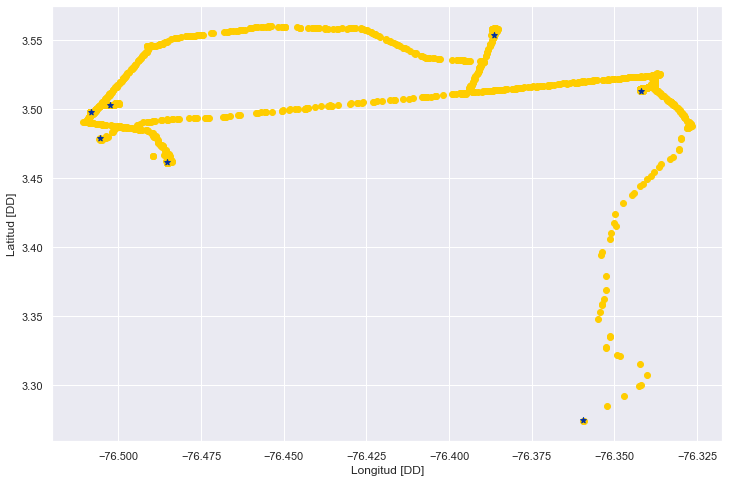

In [ ]:
plt.figure(figsize =(12,8)) 
plt.scatter(Data['Longitude(X)'], Data['Latitude(Y)'],color='#FFCD00')
plt.scatter(EstacionariosPoint['Longitude(X)'], EstacionariosPoint['Latitude(Y)'],color='#002FA5',marker='*') 
#plt.title('Registros Mes de Junio')
plt.xlabel('Longitud [DD]')
plt.ylabel('Latitud [DD]')
#plt.savefig('Datos resultantes/Junio2020/Fig9 - Junio2020Estacionarios_2D.png')
plt.show()

### Gráfica 3D

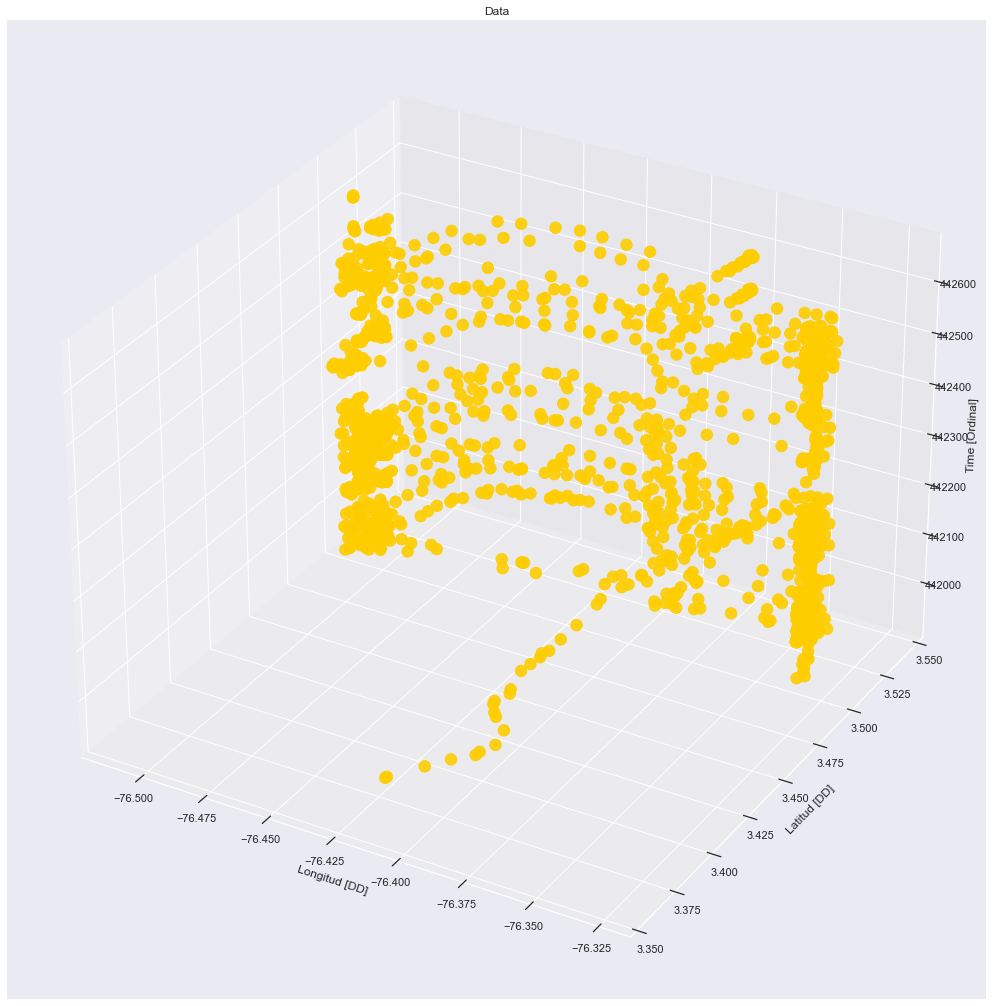

In [ ]:
fig = plt.figure(figsize =(30,18))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(arrayData[:, 0], arrayData[:, 1], arrayData[:,5], 'o', color='#FFCD00',alpha=0.9, s=130)
ax.set_title('Data')

ax.set_ylim([3.35,3.55])
ax.set_xlabel('Longitud [DD]')
ax.set_ylabel('Latitud [DD]')
ax.set_zlabel('Time [Ordinal]')
#plt.savefig('Datos resultantes/Junio2020/Fig10 - Junio2020_3D.png')
plt.show()

### Mapa de calor

In [ ]:
# Visualizar los Puntos estacionarios marcados por un marker en un mapa de calor de todos los datos.
def generateBaseMap(default_location, default_zoom_start=12):
    BaseMap = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return BaseMap

def organizarDatos(puntos):
    coordenadas = []
    for _, d in puntos.groupby('datecreated'):
        coordenadas.append([[row['Latitude(Y)'], row['Longitude(X)'], str(row['datecreated'])] for _, row in d.iterrows()])
    return coordenadas

def puntosEstacionarios(puntos):
    for i in range(len(puntos)):
        puntos[i][0][0] = round(puntos[i][0][0],6); 
        puntos[i][0][1] = round(puntos[i][0][1],6); 
        #folium.Marker([puntos[i][0][0],puntos[i][0][1]], popup='StayPoint:\nLat:\n'+str(puntos[i][0][0])+'\nLon:\n'+str(puntos[i][0][1])+'\nTime:\n'+str(puntos[i][0][2]), icon=folium.Icon(color='yellow', icon='car', prefix='fa')).add_to(dataMap)
        folium.Marker([puntos[i][0][0],puntos[i][0][1]], popup='StayPoint:\nLat:\n'+str(puntos[i][0][0])+'\nLon:\n'+str(puntos[i][0][1]), icon=folium.Icon(color='orange', icon='car', prefix='fa')).add_to(dataMap)
DataCoord = organizarDatos(Data)

# Mapa base.
dataMap = generateBaseMap(default_zoom_start=12, default_location = [3.508193,-76.502738])
# Mapa de calor.
HeatMap(data=Data[['Latitude(Y)','Longitude(X)']].groupby(['Latitude(Y)','Longitude(X)']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(dataMap)
# Mapa de calor con respecto al tiempo.
HeatMapWithTime(DataCoord, auto_play=True,max_opacity=0.8,speed_step=1).add_to(dataMap)

#Coordenadas = organizarDatos(EstacionariosPoint)
#puntosEstacionarios(Coordenadas)
#dataMap.save("Datos resultantes/Junio2020/Heatmap_Move2.html")
dataMap


## 2. Modelado

### 2.1 Selección de la métrica de distancia

#### 2.1.1 Prueba distancia Harvesine. 

DBSCAN usando Distancia Harvesine:
Agrupa 1,571 puntos dentro de 22 clusteres, para un 98.6% de comprensión de los datos en 0.68 segundos.
Cantidad de puntos clasificados como ruido: 106
Coeficiente de Silhouette: 0.202


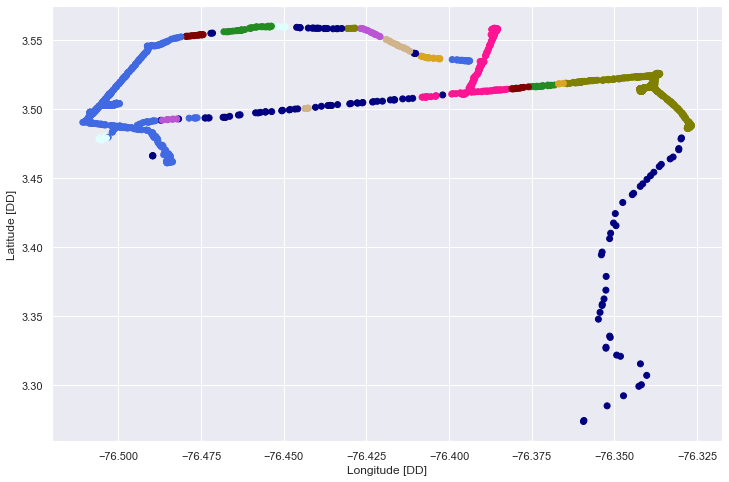

In [ ]:
# Conversiones
# Kilometros por radian.
KmPerRadian = 6371
# Kilometros a radianes. 
KmToRadian = 0.175/KmPerRadian

# Tiempo de ejecución.
startTimeHar = time.time()

# Algoritmo.
dbHar = DBSCAN(eps=KmToRadian, min_samples=5, algorithm='ball_tree', metric='haversine')
dbscanHar = dbHar.fit_predict(np.radians(Location[:,[0,1]]))

# Labels.
labelsHar = dbHar.labels_
# Number of clusters.
numClustersHar = len(set(labelsHar))
# Number of noise. 
numNoiseHar = list(labelsHar).count(-1)

# Resultados.
print('DBSCAN usando Distancia Harvesine:')
m = 'Agrupa {:,} puntos dentro de {:,} clusteres, para un {:.1f}% de comprensión de los datos en {:,.2f} segundos.'
print(m.format(len(Location), numClustersHar, 100*(1 - float(numClustersHar) / len(Location)), time.time()-startTimeHar))
print('Cantidad de puntos clasificados como ruido:',numNoiseHar)
print('Coeficiente de Silhouette: {:0.03f}'.format(metrics.silhouette_score(Location[:,[0,1]], labelsHar)))

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize =(12,8)) 
plt.xlabel('Longitude [DD]')
plt.ylabel('Latitude [DD]')
plt.scatter(Location[:,[0]], Location[:,[1]], c=vectorizer(labelsHar))
#plt.savefig('Datos resultantes/Junio2020/Fig10_Haversine1000.png')

#### 2.1.2 Prueba distancia Euclidiana. 

DBSCAN usando Distancia Euclidiana:
Agrupa 1,571 puntos dentro de 42 clusteres, para un 97.3% de comprensión de los datos en 0.08 segundos.
Cantidad de puntos clasificados como ruido: 136
Coeficiente de Silhouette: 0.455


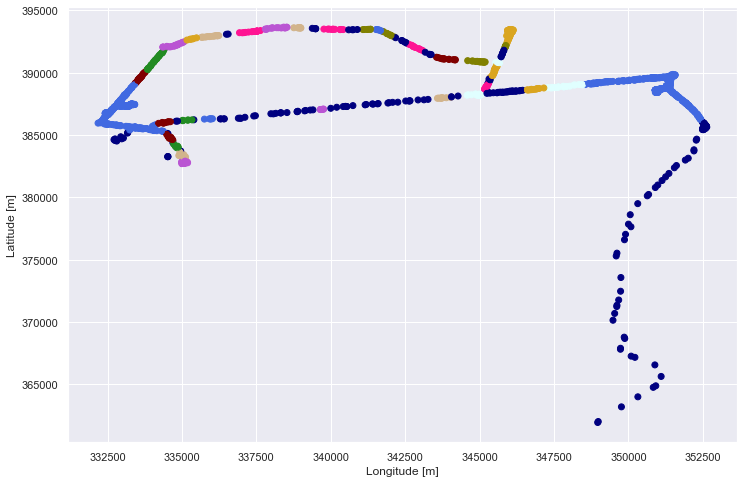

In [ ]:
startTimeEu = time.time()
dbeu = DBSCAN(eps=175, min_samples=5, algorithm='kd_tree', metric='euclidean')
dbscanEu = dbeu.fit(Location[:,[2,3]])

labelsEu = dbeu.labels_
numClustersEu = len(set(labelsEu)) 
numNoiseEu = list(labelsEu).count(-1)

# Resultados.
print('DBSCAN usando Distancia Euclidiana:')
mEu = 'Agrupa {:,} puntos dentro de {:,} clusteres, para un {:.1f}% de comprensión de los datos en {:,.2f} segundos.'
print(mEu.format(len(Location), numClustersEu, 100*(1 - float(numClustersEu) / len(Location)), time.time()-startTimeEu))
print('Cantidad de puntos clasificados como ruido:',numNoiseEu)
print('Coeficiente de Silhouette: {:0.03f}'.format(metrics.silhouette_score(Location[:,[2,3]], labelsEu)))

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.figure(figsize =(12,8)) 
plt.xlabel('Longitude [m]')
plt.ylabel('Latitude [m]')
plt.scatter(Location[:,[2]], Location[:,[3]], c=vectorizer(labelsEu)) #c=labelsEu, cmap='rainbow')
#plt.savefig('Datos resultantes/Junio2020/Fig11_Euclidiana50.png')

Después de comparar los resultados obtenidos de DBSCAN para distintos valores de epsilon utilizando métricas Harvesine y Euclidiana, _se decide utilizar la distancia Euclidiana_ para los próximos pasos de la etapa de modelado. 

#### Centro de los clústeres

In [ ]:
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

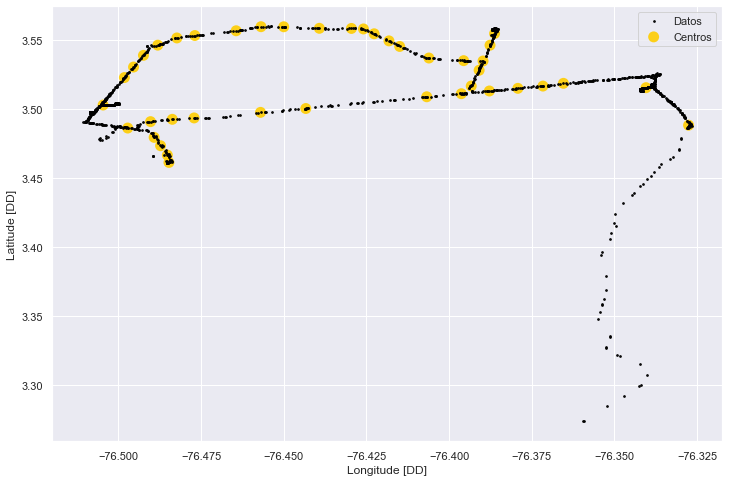

In [ ]:
clustersEu = pd.Series([Location[:,[0,1]][labelsEu==n] for n in range(numClustersEu-1)])
centerPointsEu = clustersEu.map(get_centermost_point)

longsEu,latdsEu = zip(*centerPointsEu)

PointsEu = pd.DataFrame({'Longitude(X)':longsEu, 'Latitude(Y)':latdsEu})
PointsEu.head() #Points.info()

fig, ax = plt.subplots(figsize=[12, 8])
ct_scatter = ax.scatter(PointsEu['Longitude(X)'], PointsEu['Latitude(Y)'], c='#FFCD00', edgecolor='None', alpha=0.9, s=120)
df_scatter = ax.scatter(Location[:, 0], Location[:, 1], c='#000000', alpha=0.9, s=3)
#ax.set_title('Full data t vs DBSCAN [Euclidean] center points.')
ax.set_xlabel('Longitude [DD]')
ax.set_ylabel('Latitude [DD]')
ax.legend([df_scatter, ct_scatter], ['Datos', 'Centros'], loc='upper right')
#plt.savefig('Datos resultantes/Junio2020/Fig11 - Junio2020_EuclidianaCentro175.png')
plt.show()

## 3. Clustering 

### 3.1 Coeficiente de correlación cofenética

In [ ]:
# Para Aglomerattive algorithm UTM 5 y 6
XAglo = (Data.iloc[0:,[5,6]]).values
link = shc.linkage(XAglo, method='average', metric='euclidean')

# Cálculo de Cophenetic Correlation Coefficient para validad el método de vinculación.
c, coph_dists = cophenet(link, pdist(XAglo))
print("Coeficiente de correlación cofenética: ", c)

Coeficiente de correlación cofenética:  0.912806094615119


### 3.2 Dendrograma

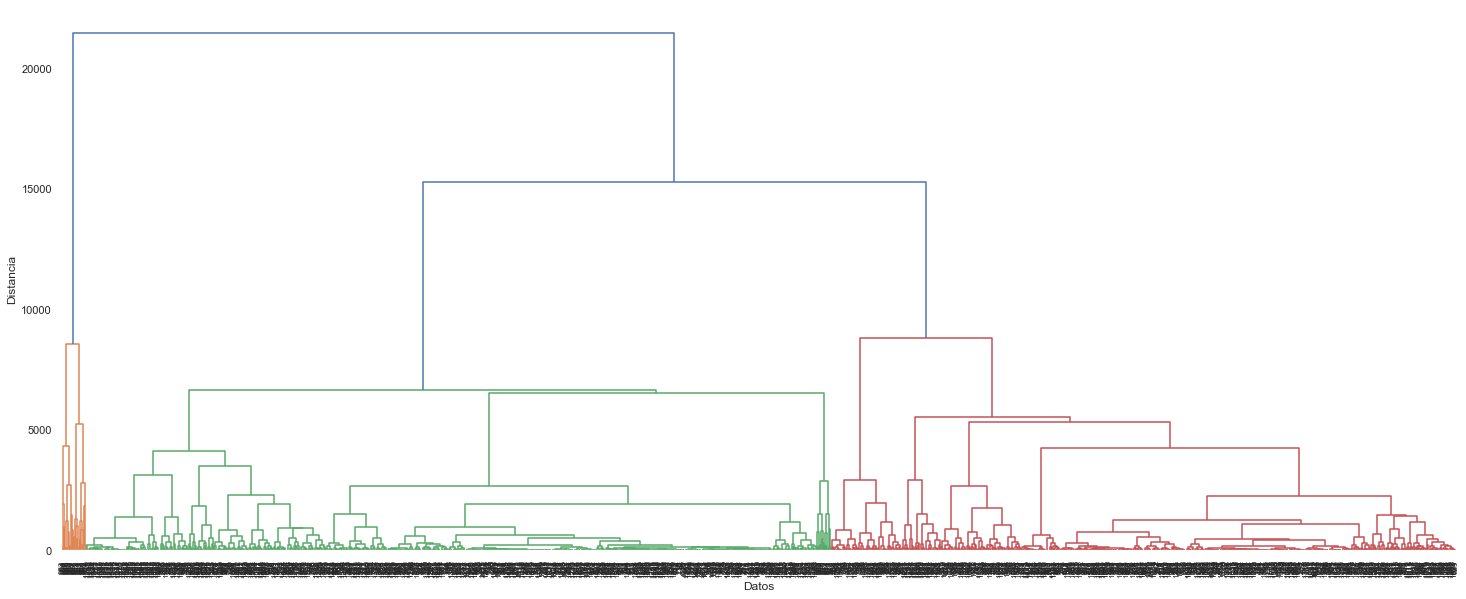

In [ ]:
# Dendograma Completo
plt.figure(figsize=(25, 10))
plt.xlabel('Datos')
plt.ylabel('Distancia')
shc.dendrogram(link,
    leaf_rotation=90., 
    leaf_font_size=8.,
)
#plt.savefig('Datos resultantes/Junio2020/Fig12_Junio2020_Dendograma-Completo.png')
plt.show()

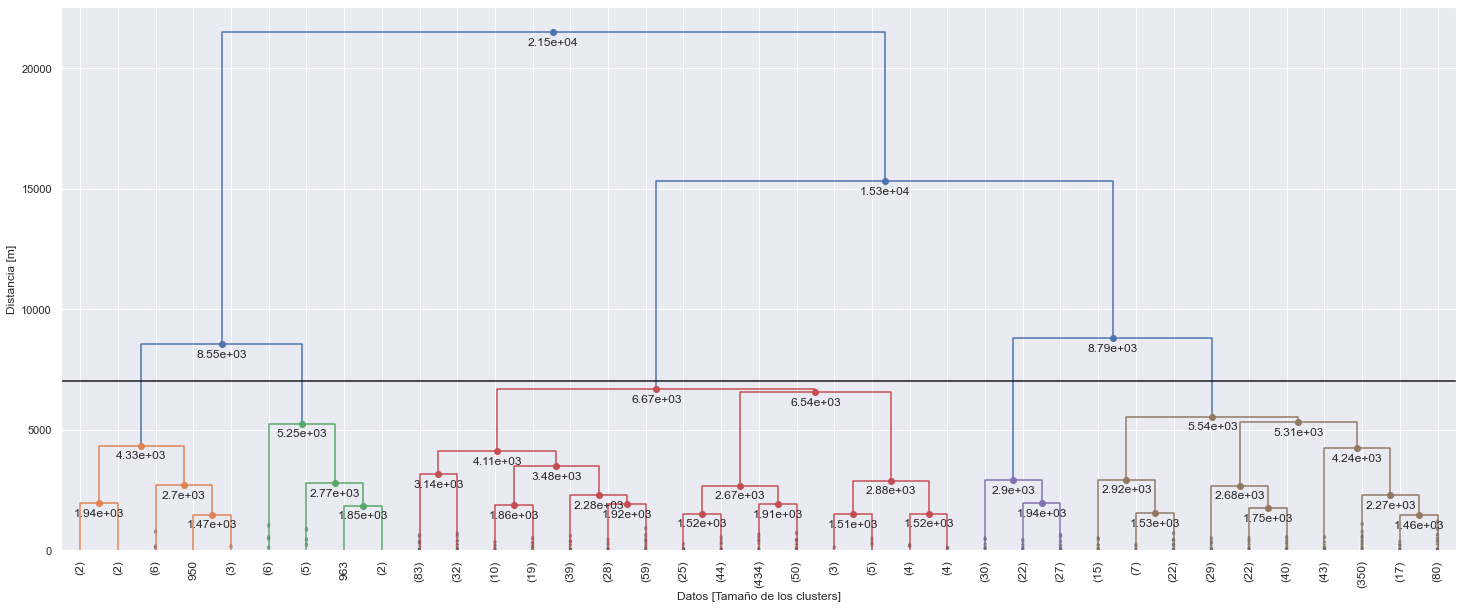

In [ ]:
def dendrogramaTruncado(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = shc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Dendograma truncado del Clustering aglomerativo jerárquico')
        plt.xlabel('Datos [Tamaño de los clusters]')
        plt.ylabel('Distancia [m]')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

plt.figure(figsize=(25, 10))
dendrogramaTruncado(
    link,
    truncate_mode='lastp',
    p=37,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d= 7000,
)

#plt.savefig('Datos resultantes/Junio2020/Dendrograma-Truncado-Marcado7km.png')
plt.show()

### 3.3 Algoritmo: Clustering aglomerativo jerárquico 

Coeficiente de Silhouette: 0.639


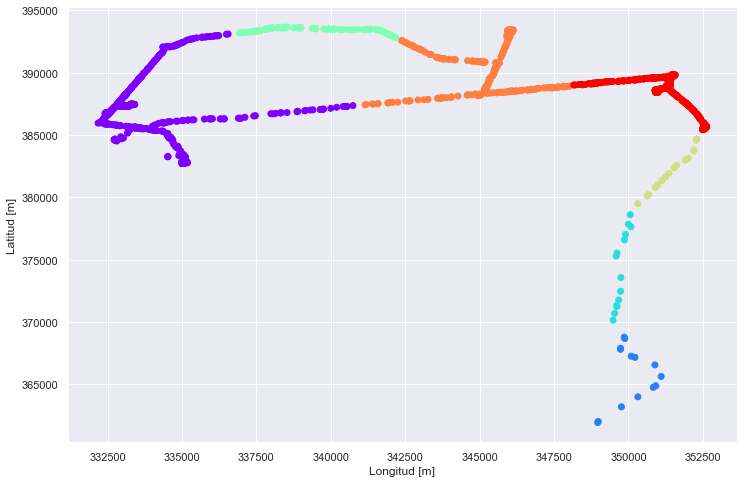

In [ ]:
clusters=7
cluster = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='average')
cluster.fit_predict(XAglo)
labelsAglo = cluster.labels_

plt.figure(figsize=(12, 8))
#plt.title('Resultado del Clustering aglomerativo jerárquico - No. Clusters = '+ str(clusters))
plt.ylabel('Latitud [m]')
plt.xlabel('Longitud [m]')
plt.scatter(XAglo[:,0], XAglo[:,1], c=labelsAglo, cmap='rainbow')
#plt.savefig('Datos resultantes/Junio2020/Fig13_Junio2020_Aglo7C_0639.png')
print('Coeficiente de Silhouette: {:0.03f}'.format(metrics.silhouette_score(XAglo[:,[0,1]], labelsAglo)))

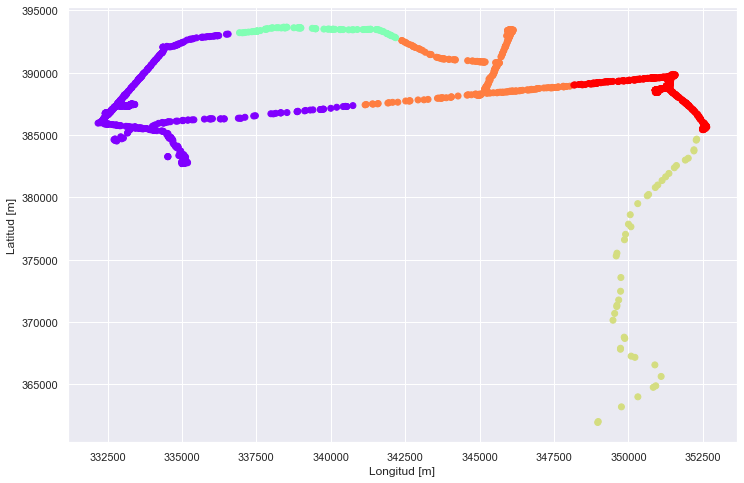

In [ ]:
# Combinar los clústeres de la ruta sur. 
Data["AgloLabel"] = labelsAglo
for i, row in Data.iterrows():
    if (Data.at[i,"AgloLabel"] == 1 or Data.at[i,"AgloLabel"] == 2): 
        Data.at[i,"AgloLabel"]=4
        
#Data.to_csv('Datos resultantes/Junio2020/Junio2020-ClusteresAglo2.csv')

plt.figure(figsize=(12, 8))
#plt.title('Resultado del Clustering aglomerativo jerárquico - No. Clusters = '+ str(clusters))
plt.xlabel('Longitud [m]')
plt.ylabel('Latitud [m]')
plt.scatter(XAglo[:,0], XAglo[:,1], c=(Data.iloc[0:,[7]]).values, cmap='rainbow')
#plt.savefig('Datos resultantes/Junio2020/Fig13_Junio2020_Aglomerativo.png')

#### Composición de cada clúster - (Para guardar los archivos del modelo aglomerativo)

In [ ]:
# Clusteres en cvs
for i in range(0,7):
    Cluster = Data[Data["AgloLabel"] == i]
    #Cluster.to_csv('Datos resultantes/Junio2020/Clusteres/Junio2020-Cluster'+str(i)+'_Aglo.csv') 

### 3.4 Cálculo de los parámetros para ST-DBSCAN

#### 3.4.1 Espacial

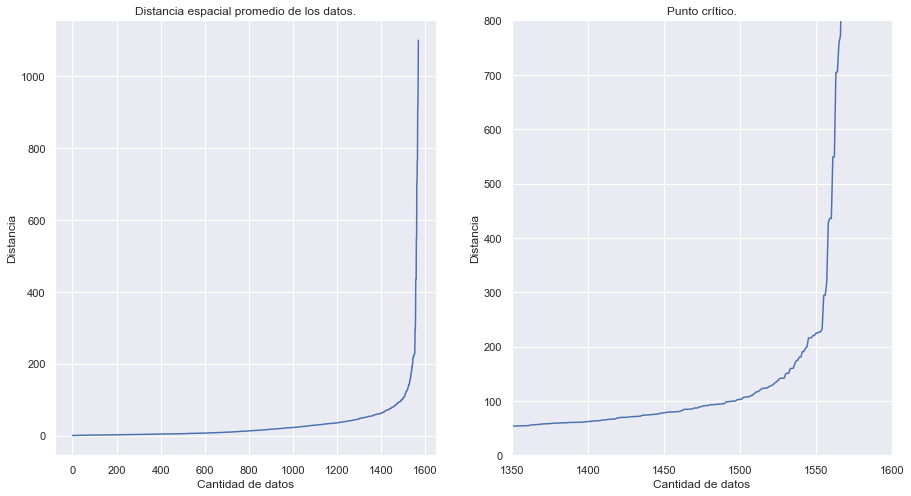

In [ ]:
# Calcular la distancia entre todas las muestras.
neighEspacio = NearestNeighbors(n_neighbors=20,algorithm='kd_tree')
nbrsEspacio = neighEspacio.fit(LocationUTM)

# Calcula la distancia promedio entre sus n vecinos cercanos.
distances, indices = nbrsEspacio.kneighbors(LocationUTM) 
distances = np.sort(distances, axis=0)

# Eje y es la distancia y Eje x la cantidad de datos.
distances = distances[:,1] 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

ax1.set_title('Distancia espacial promedio de los datos.')
ax1.set_xlabel('Cantidad de datos')
ax1.set_ylabel('Distancia')
ax1.plot(distances)

ax2.set_title('Punto crítico.')
ax2.set_xlabel('Cantidad de datos')
ax2.set_ylabel('Distancia')
ax2.set_ylim([0,800])
ax2.set_xlim([1350,1600])
ax2.plot(distances)

#plt.savefig('Datos resultantes/Junio2020/MinDistancia.png')

#### 3.4.2 Temporal

In [ ]:
# La distancia temporal, será el promedio de las diferencias de tiempo.
meanTimeDiff = round(Data['deltaTime'].mean(axis=0),0)
maxTimeDiff = round(Data['deltaTime'].max(axis=0),0)
print ('Máximo deltaTime:',maxTimeDiff)
print ('Diferencia temporal media:',meanTimeDiff)

Máximo deltaTime: 198130.0
Diferencia temporal media: 732.0


### 3.5 Algoritmo ST-DBSCAN

In [ ]:
Data['deltaTime'][0] = 0

datos = Data.loc[0:, ['time','LonUTM(X)','LatUTM(Y)']].values

start_time3 = time.time()
st_dbscan = ST_DBSCAN(eps1=800, eps2=700, min_samples=20).fit(datos)

labelsSTDBSCAN = st_dbscan.labels
numClusters = len(set(labelsSTDBSCAN))
numNoise = list(labelsSTDBSCAN).count(-1)

message = '{:,} puntos se segmentaron en {:,} clusters. Logrando el  {:.1f}% de comprensión en {:,.2f} segundos.'
print(message.format(len(datos), numClusters, 100*(1 - float(numClusters) / len(datos)),time.time()-start_time3))
print('Cantidad de valores atípicos', numNoise)
print('Coeficiente de Silhouette: {:0.03f}'.format(metrics.silhouette_score(datos, labelsSTDBSCAN)))

1,571 puntos se segmentaron en 5 clusters. Logrando el  99.7% de comprensión en 0.29 segundos.
Cantidad de valores atípicos 120
Coeficiente de Silhouette: 0.501


#### Composición de cada clúster - (Para guardar los archivos del modelo ST-DBSCAN)

In [ ]:
Data["STDLabel"] = labelsSTDBSCAN
for i in range(-1,4):
    Cluster = Data[Data["STDLabel"] == i]
    #Cluster.to_csv('Datos resultantes/Junio2020/Clusteres/Junio2020-Cluster'+str(i)+'_STD.csv')

### 3.6 Intersección de los clústeres de los 2 Algoritmos

Coeficiente de Silhouette de los clústeres finales del Aglomerativo: 0.609


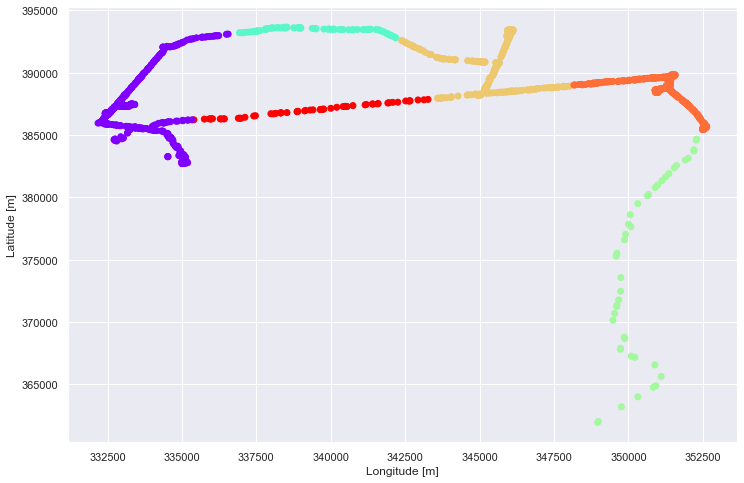

In [ ]:
#  Reducción de los clústeres.
for i, row in Data.iterrows():
    if (Data.at[i,"STDLabel"] == -1 and (Data.at[i,"AgloLabel"] == 0 or Data.at[i,"AgloLabel"] == 5)): 
        if (Data.at[i,"LatUTM(Y)"] < 390000):
            Data.at[i,"AgloLabel"] = 7

for i, row in Data.iterrows():
    if (Data.at[i,"STDLabel"] == -1 and Data.at[i,"AgloLabel"] == 4): 
        Data.at[i,"STDLabel"] = 5
    if (Data.at[i,"STDLabel"] == -1 and Data.at[i,"AgloLabel"] == 7): 
        Data.at[i,"STDLabel"] = 6
    if (Data.at[i,"STDLabel"] == -1 and Data.at[i,"AgloLabel"] == 5): 
        Data.at[i,"STDLabel"] = 3

for i, row in Data.iterrows():
    if (Data.at[i,"STDLabel"] == 1 and Data.at[i,"AgloLabel"] == 3): 
        Data.at[i,"STDLabel"] = 1
    if (Data.at[i,"STDLabel"] == 2 and Data.at[i,"AgloLabel"] == 3): 
        Data.at[i,"STDLabel"] = 1
    if (Data.at[i,"STDLabel"] == 2 and Data.at[i,"AgloLabel"] == 5): 
        Data.at[i,"STDLabel"] = 3
    
#Data.to_csv('Datos resultantes/Junio2020/Clusteres/Junio2020-ClusteresFinales2.csv') 

plt.figure(figsize=(12, 8))
#plt.title('Resultado del Clustering aglomerativo jerárquico - No. Clusters = '+ str(clusters))
plt.ylabel('Latitude [m]')
plt.xlabel('Longitude [m]')

# Coeficiente de correlación de Silhouette de los clústeres finales del Aglomerativo.
plt.scatter(XAglo[:,0], XAglo[:,1], c=(Data.iloc[0:,[7]]).values, cmap='rainbow')
print('Coeficiente de Silhouette de los clústeres finales del Aglomerativo: {:0.03f}'.format(metrics.silhouette_score(datos, (Data.iloc[0:,[7]]).values)))
#plt.savefig('Datos resultantes/Junio2020/Clusteres/Inter.png')

### 3.7 Gráficas de los clusters finales

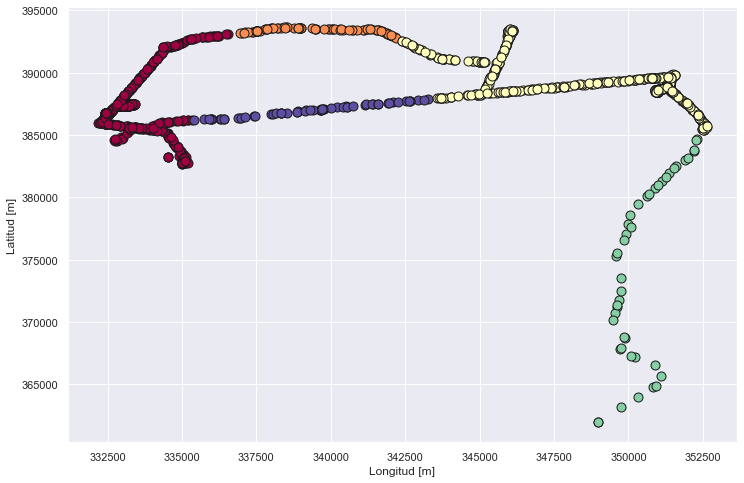

Coeficiente de Silhouette de los clústeres finales: 0.550


In [ ]:
def plotClusters2D(df, output_name, title): 
    labels = output_name
    X = df
    plt.figure(figsize =(12,8))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            class_noise_mask = (labels == k)
            noise = X[class_noise_mask]
            col = [0, 0, 0, 1]
            #plt.plot(noise[:, 0], noise[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=9)

        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        if k == -1:
            plt.plot(xy[:, 2], xy[:, 3],'o', markerfacecolor='#000000',markeredgecolor='k', markersize=9)
        else:
            plt.plot(xy[:, 2], xy[:, 3],'o',markerfacecolor=tuple(col),markeredgecolor='k', markersize=9)
    
    plt.title(title.format(len(unique_labels)))
    plt.ylabel('Latitud [m]')
    plt.xlabel('Longitud [m]')
    #plt.scatter(XAglo[:,0], XAglo[:,1], c=(Data.iloc[0:,[7]]).values, cmap='rainbow', marker='o', s=200)
    #plt.savefig('Datos resultantes/Junio2020/Clusteres/Junio2020-ClusteresFinales-6Azul.png')
    plt.show()

# Coeficiente de correlación de Silhouette de los clústeres final.
#plotClusters2D(arrayData[:,[0,1,3,4,5,2]], st_dbscan.labels[:],"")
finalLabels = (Data.iloc[:,8]).values
plotClusters2D(arrayData[:,[0,1,3,4,5,2]], finalLabels,"")
print('Coeficiente de Silhouette de los clústeres finales: {:0.03f}'.format(metrics.silhouette_score(datos, (Data.iloc[0:,[8]]).values)))

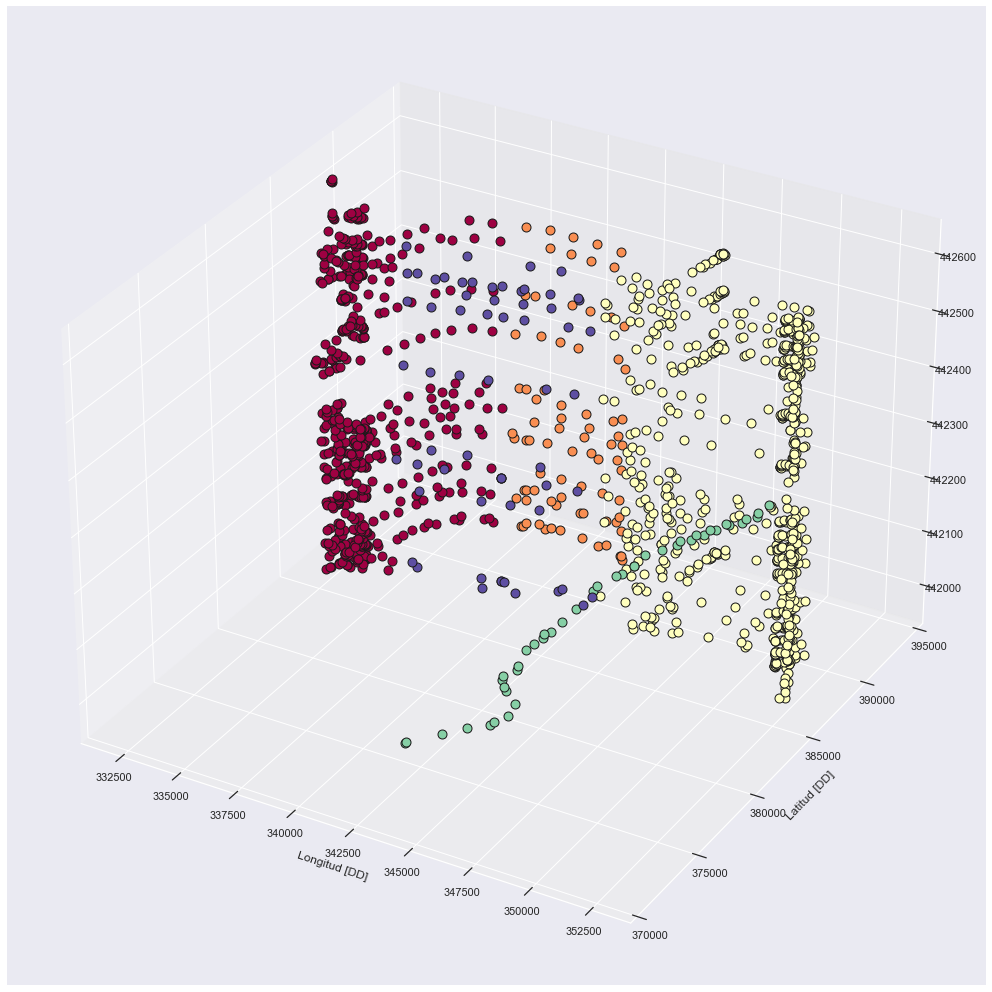

In [ ]:
def plotClusters3D(df, dfLabels, title):
    labels = dfLabels
    X = df
    fig = plt.figure(figsize =(30,18))
    ax = fig.add_subplot(111,projection='3d')
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        Clusteres[k] = {}
        if k == -1:
            class_noise_mask = (labels == k)
            noise = X[class_noise_mask]
            #print(len(noise),noise)
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        Clusteres[k]["Longitud"] = xy[:,2]; Clusteres[k]["Latitud"] = xy[:,3]; Clusteres[k]["datecreated"] = xy[:,5];
        #print(xy[4])  #Clusters points
        #print(len(xy))  #Clusters size
        ax.plot(xy[:,2], xy[:,3], xy[:,4], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=9)
    ax.set_ylim([370000,395000])
    plt.xlabel('Longitud [DD]')
    plt.ylabel('Latitud [DD]')
    plt.title(title.format(len(unique_labels)))
    #plt.savefig('Datos resultantes/Junio2020/Clusteres/ClusteresFinales_3D.png')
    plt.show()
    
plotClusters3D(arrayData[:,[0,1,3,4,5,2]], (Data.iloc[:,8]).values,"")

#### Guardar los archivos de los clústeres finales

In [ ]:
for i in range(0,7):
    Cluster = Data[Data["STDLabel"] == i]
    #Cluster.to_csv('Datos resultantes/Junio2020/Clusteres/Junio2020-ClusterFinal'+str(i)+'_STD.csv')

## 4. Cálculo de la Envolvente Compleja

### 4.1 Convex Hull - Antes de la minería de datos. 

Vertices:
 Longitud (x): [332750.35 348969.84 350921.71 351101.41 352635.09 352619.55 351571.05
 351563.18 346082.83 346049.29 346027.96 338418.61 338034.02 335489.24
 335276.09 335169.66 334362.16 332432.69 332418.39 332181.59 332717.01] 
 Latitud (y): [384553.61 361946.94 364888.42 365639.13 385628.77 385717.68 389807.07
 389820.12 393446.21 393452.89 393454.69 393642.66 393587.09 392784.97
 392677.95 392607.35 392044.51 386775.97 386729.33 385947.3 384621.89]


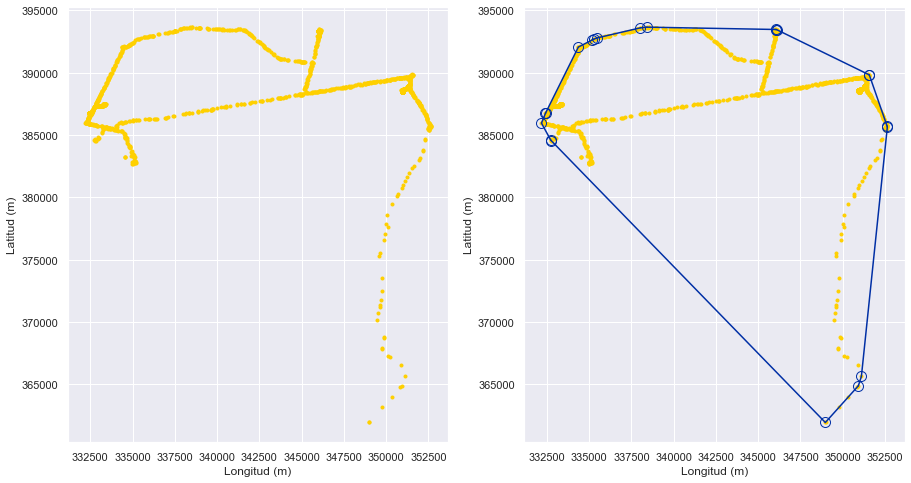

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
plt.xlabel('Longitud (m)')
plt.ylabel('Latitud (m)')

LocationUTM = (Data.iloc[0:,[5,6]]).values
hull = ConvexHull(LocationUTM)

for ax in (ax1, ax2):
    ax.plot(arrayData[:, 3], arrayData[:, 4], '.', color='#FFD000')
    if ax == ax1:
        #ax.set_title('Puntos originales')
        ax.set_xlabel('Longitud (m)')
        ax.set_ylabel('Latitud (m)')
    else:
        #ax.set_title('Convex Hull result')
        for simplex in hull.simplices:
            ax.plot(arrayData[simplex, 3], arrayData[simplex, 4], '#002FA5')
        ax.plot(arrayData[hull.vertices, 3], arrayData[hull.vertices, 4], 'o', mec='#002FA5', color='none', lw=1, markersize=10)

print(f"Vertices:\n","Longitud (x):",arrayData[hull.vertices, 3],"\n Latitud (y):", arrayData[hull.vertices, 4])
#plt.savefig('Datos resultantes/Junio2020/Clusteres/Junio2020-ConvexHull_Completo.png')
plt.show()

### 4.2 Convex Hull particionado - Después de la minería de datos.

In [ ]:
def convexCluster(df, output_name, title): ## Noise!
    labels = output_name
    X = df
    plt.figure(figsize =(15,8))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(15,8))
        if k == -1:
            class_noise_mask = (labels == k)
            noise = X[class_noise_mask]
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        
        hull = ConvexHull(xy[:,[0,1]])
        
        #for ax in (ax1, ax2):
        #ax1.plot(df[:, 0], df[:, 1], '.', color='k')
        ax3.plot(arrayData[:, 0], arrayData[:, 1], '.', color='#FFD000')
        #if ax == ax1:
         #   ax.set_title('Original Points')
          #  ax.set_xlabel('Longitude (UTM)')
           # ax.set_ylabel('Latitude (UTM)')
        #else:
        #ax2.set_title('Envolvente compleja del Cluster'+str(k))
        for simplex in hull.simplices:
            ax1.set_xlabel('Longitud (DD)')
            ax1.set_ylabel('Latitud (DD)')
            ax3.set_xlabel('Longitud (DD)')
            ax3.set_ylabel('Latitud (DD)')
            ax1.plot(xy[:,[0]], xy[:,[1]], '.', markerfacecolor=tuple(col),markeredgecolor='k',markersize=9)
            #ax2.plot(xy[simplex, 0], xy[simplex, 1], 'b')
            ax3.plot(xy[simplex, 0], xy[simplex, 1], '#002FA5')
        
        #ax2.plot(xy[hull.vertices, 0], xy[hull.vertices, 1], 'o', mec='#002FA5', color='none', lw=1, markersize=10)
        ax3.plot(xy[hull.vertices, 0], xy[hull.vertices, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=9)
        print(f"Label:", k," No. puntos:", len(xy)," No. vértices:", len(xy[hull.vertices, 0]),"\nVertices:\n","Longitud (x):",xy[hull.vertices, 0],"\n Latitud (y):", xy[hull.vertices, 1],)
        #plt.savefig('Datos resultantes/Junio2020/Clusteres/Junio2020-ConvexHull_Cluster'+str(k)+'.png')
        plt.show()

Label: 0  No. puntos: 580  No. vértices: 16 
Vertices:
 Longitud (x): [-76.505612 -76.485383 -76.485033 -76.484843 -76.484239 -76.483632
 -76.471511 -76.472031 -76.481079 -76.482996 -76.483953 -76.491213
 -76.508503 -76.508631 -76.510751 -76.505913] 
 Latitud (y): [3.477928 3.461198 3.461296 3.461352 3.461535 3.46182 3.555163 3.555026
 3.552411 3.55144 3.5508 3.545698 3.498022 3.4976 3.490524 3.478545]


<Figure size 1080x576 with 0 Axes>

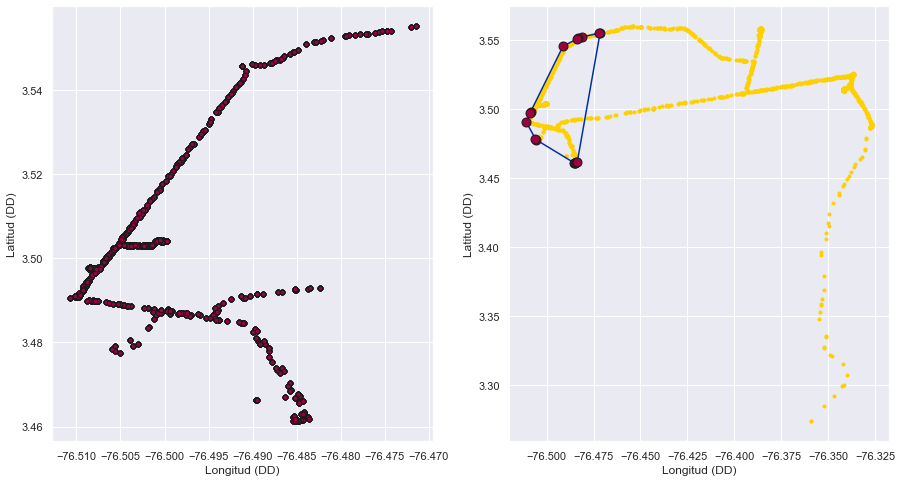

Label: 1  No. puntos: 79  No. vértices: 12 
Vertices:
 Longitud (x): [-76.468078 -76.46722 -76.420845 -76.421171 -76.424486 -76.42588
 -76.426172 -76.426675 -76.428491 -76.453875 -76.454724 -76.458185] 
 Latitud (y): [3.556159 3.556085 3.552599 3.553057 3.556922 3.558183 3.558358 3.558532
 3.55874 3.560163 3.56021 3.559702]


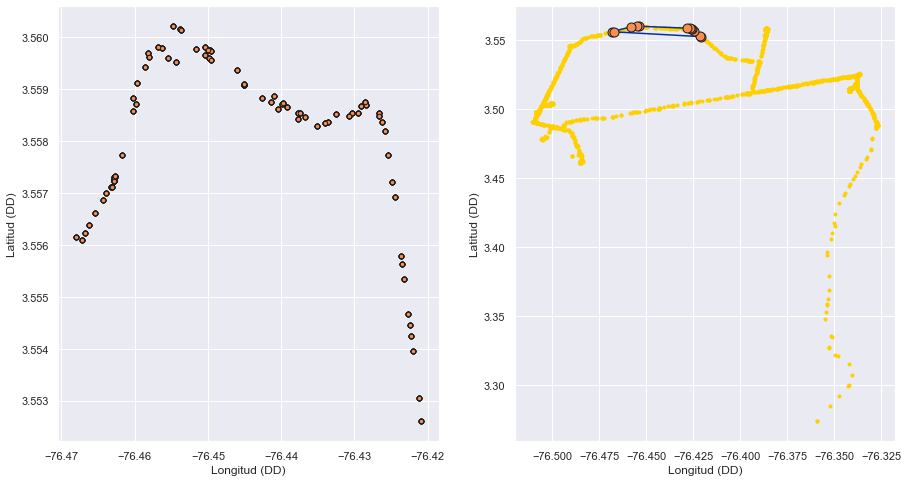

Label: 3  No. puntos: 807  No. vértices: 12 
Vertices:
 Longitud (x): [-76.418986 -76.408141 -76.32969 -76.326654 -76.326795 -76.336285
 -76.336356 -76.385734 -76.386036 -76.386228 -76.386327 -76.386432] 
 Latitud (y): [3.550558 3.508703 3.479198 3.487922 3.488726 3.525699 3.525817 3.55854
 3.5586 3.558616 3.558607 3.558589]


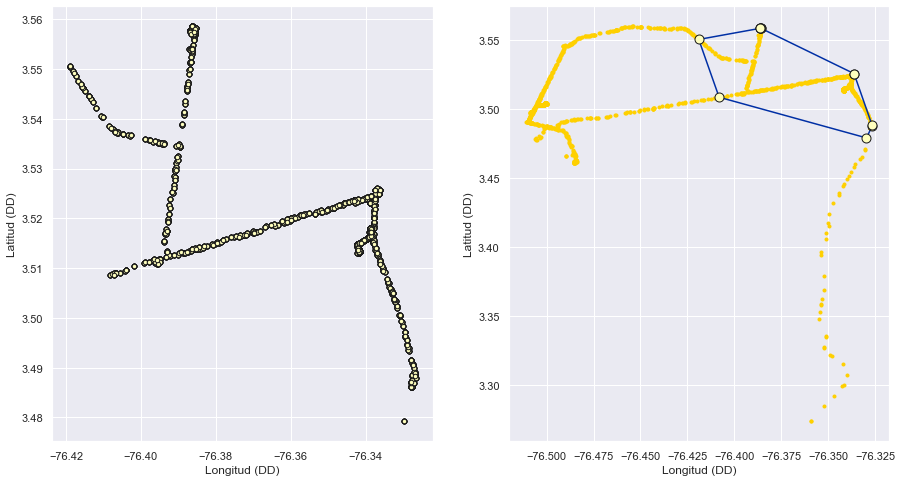

Label: 5  No. puntos: 43  No. vértices: 8 
Vertices:
 Longitud (x): [-76.340209 -76.329842 -76.347454 -76.349715 -76.353692 -76.353914
 -76.359346 -76.341817] 
 Latitud (y): [3.307106 3.478446 3.432393 3.424368 3.396477 3.394455 3.273686 3.300314]


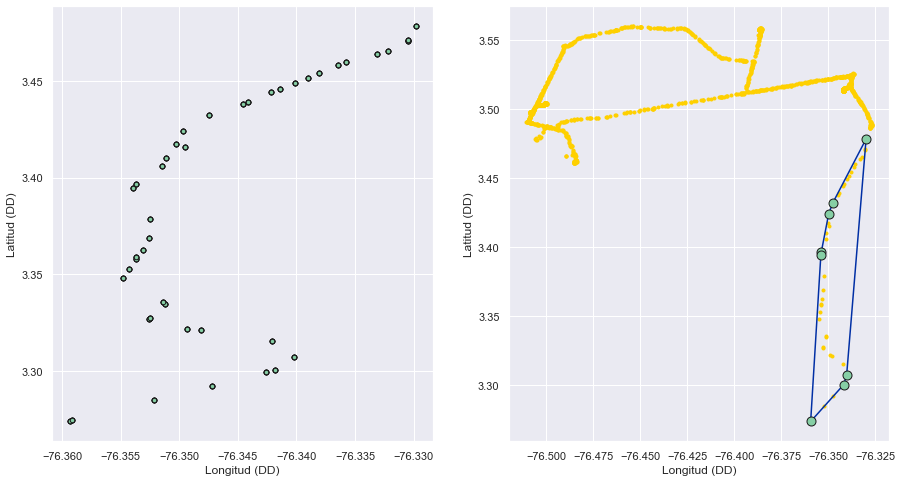

Label: 6  No. puntos: 62  No. vértices: 9 
Vertices:
 Longitud (x): [-76.433699 -76.481772 -76.472757 -76.467548 -76.412223 -76.410984
 -76.414014 -76.417739 -76.427812] 
 Latitud (y): [3.50335 3.492987 3.493661 3.494062 3.507582 3.507894 3.507489 3.50672
 3.504611]


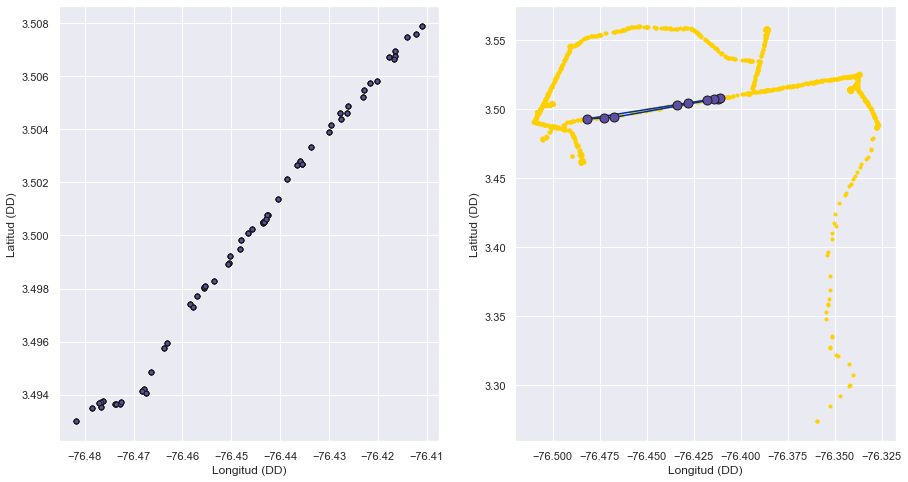

In [ ]:
#agloLabels = (Data.iloc[0:,[7]]).values
finalLabels = (Data.iloc[0:,[8]]).values
convexCluster(arrayData[:,[0,1,3,4,5,2]], finalLabels[:,0],"")

## 5. Resultados

#### 5.1 Dataframe - Vertices

In [ ]:
def vertices(df, output_name):
    Lon = []; Lat = []; Date = []; Lab = []
    labels = output_name
    X = df
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    #data = np.array([[1, 2, 2]])
    final = pd.DataFrame(columns=['Longitude(X)','Latitude(Y)','Date','Lab'])
    for k, col in zip(unique_labels, colors):
        #if k == -1:
        #    class_noise_mask = (labels == k)
        #   noise = X[class_noise_mask]
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        hull = ConvexHull(xy[:,[0,1]])
        d = {'Lon':xy[hull.vertices, 0], 'Lat':xy[hull.vertices, 1], 'Date':xy[hull.vertices,2], 'Lab':k}
        dff = pd.DataFrame(d)
        final = final.append(dff)
    return final

d = (Data.iloc[:,[0,1,2]]).values
Vertices = vertices(d[:,[0,1,2]],finalLabels[:,0])
#Vertices.to_csv('Datos resultantes/Junio2020/Clusteres/Junio2020-Vertices.csv')

Vertices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 8
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Longitude(X)  0 non-null      object        
 1   Latitude(Y)   0 non-null      object        
 2   Date          57 non-null     datetime64[ns]
 3   Lab           57 non-null     object        
 4   Lon           57 non-null     object        
 5   Lat           57 non-null     object        
dtypes: datetime64[ns](1), object(5)
memory usage: 3.1+ KB


#### 5.2 Funciones para pasar a formato GeoJSON para guardar la información

In [ ]:
def dataframe_to_geojson(df, properties, lat='Latitude(Y)', lon='Longitude(X)'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        feature['geometry']['coordinates'] = [row[lon],row[lat]]

        for prop in properties:
            feature['properties'][prop] = row[prop]
            
        geojson['features'].append(feature)
    
    return geojson

def clusteres_to_geojson(df, properties, lat='Latitude(Y)', lon='Longitude(X)'):
    ju = []; da = []
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        if row[properties[1]] not in ju:
            ju.append(row[properties[1]]);
            feature = {'type':'Feature',
                       'properties':{},
                       'geometry':{'type':'MultiPoint',
                                   'coordinates':[]}}
            for prop in properties:
                if prop == 'Dates' or prop == 'datecreated':
                    feature['properties'][prop] = []
                elif prop == 'deltaTime':
                    feature['properties'][prop] = []
                else:
                    feature['properties'][prop] = row[prop]
                    
            for _, row2 in df.iterrows():
                if row2[properties[1]] == row[properties[1]]: 
                    feature['geometry']['coordinates'].append([row2[lon],row2[lat]])
                    feature['properties'][properties[0]].append(row2[properties[0]])
                    if len(properties) == 3:
                        feature['properties'][properties[2]].append(row2[properties[2]])
                    
            geojson['features'].append(feature)
    
    return geojson

#### 5.3 Generar los archivos con los resultados

In [ ]:
Data['datecreated'] = Data['datecreated'].astype(str)

# Datos generales
col = ['datecreated','deltaTime','STDLabel']
#geojsonData = dataframe_to_geojson(Data, col)
#geojsonData_str = json.dumps(geojsonData, indent=4)

# Puntos estacionarios
colEst = ['Dates','Deltas']
#geojsonEst = dataframe_to_geojson(EstacionariosPoint, colEst)
#geojsonEst_str = json.dumps(geojsonEst, indent=4)

# Clústeres
colClus = ['datecreated', 'STDLabel', 'deltaTime']
#geojsonClus = clusteres_to_geojson(Data, colClus)
#geojsonClus_str = json.dumps(geojsonClus, indent=4)

# Vértices
colVer = ['Date', 'Lab']
#geojsonVer = clusteres_to_geojson(Vertices, colVer)
#geojsonVer_str = json.dumps(geojsonVer, indent=4)

#archivo = 'Datos.json'
#with open(archivo, 'w') as file:
#    file.write('{}'.format(geojsonData))
    
#print('{} Puntos guardados en el archivo.'.format(len(geojsonData['features'])))

#### 5.4 Función para organizar los puntos por día

In [ ]:
def rutas_to_geojson(df, properties, lat='Latitude(Y)', lon='Longitude(X)'):
    ju = [];
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        fechaIn = row[properties[0]][0:10]
        if fechaIn not in ju:
            ju.append(fechaIn);
        
            feature = {'type':'Feature',
                           'properties':{},
                           'geometry':{'type':'LineString',
                                       'coordinates':[]}}
            
            for prop in properties:
                if prop == 'datecreated':
                    feature['properties'][prop] = [row[prop][0:10]]
                else: 
                    feature['properties'][prop] = []
                        
                        
            for _, row2 in df.iterrows():
                fechaRe = row2[properties[0]][0:10]
                if fechaIn == fechaRe:
                    feature['geometry']['coordinates'].append([row2[lon],row2[lat]])
                    feature['properties'][properties[1]].append(row2[properties[0]][11:])
                    feature['properties'][properties[2]].append(row2[properties[2]])
                    feature['properties'][properties[3]].append(row2[properties[3]])
            
            geojson['features'].append(feature)
    
    return geojson

#col = ['datecreated','hours','deltaTime','STDLabel']
#geojsonData = rutas_to_geojson(Data, col)
#geojsonData_str = json.dumps(geojsonData, indent=4)

#archivo = 'RutasxDia.json'
#with open(archivo, 'w') as file:
#    file.write('{}'.format(geojsonData))

👩‍🎓 ⚡ <b>Autora: Allison E. Fernández Lobo.<br>
TFM - MUSS 2021.<br>
Universidad Politécnica de Madrid.</b>